In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import theano
floatX = theano.config.floatX
import pymc3 as pm
import theano.tensor as T
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')
sns.set_style('white')
from sklearn import datasets

/Users/jonpvandermause/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Read in dataset.

In [2]:
# read in calculation data (computed elsewhere)
str_pref = '/Users/jonpvandermause/Desktop/store/'

# read in the calculation data
sim_no = 150
ens = []
seps= []
fours = []

min_en = 0
eq_sep = 0

for n in range(sim_no):
    # load separation, energy, and density
    sep = np.load(str_pref+'sep_store/sep'+str(n)+'.npy')
    en = np.load(str_pref+'en_store/en'+str(n)+'.npy')
    four = np.load(str_pref+'four_store/four'+str(n)+'.npy')

    # put results in a nicer format
    sep = np.reshape(sep,(1,))[0]
    en = np.reshape(en,(1,))[0]['energy']
    four = np.real(four)
    
    # get min energy and equilibrium separation
    if en < min_en:
        min_en = en
        eq_sep = sep

    # store quantities
    ens.append(en)
    seps.append(sep)
    fours.append(four)

print('The minimum energy is '+str(min_en)+' eV. The equilibrium separation is '+str(eq_sep)+' Angstrom.')

The minimum energy is -31.74695245487133 eV. The equilibrium separation is 0.7483221476510067 Angstrom.


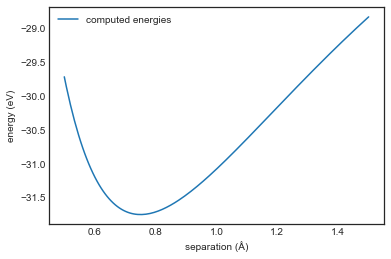

In [3]:
# create figure
figure = plt.figure()
ax = figure.add_subplot(1,1,1)

# add computed energies
ax.plot(seps, ens, label='computed energies')

ax.set_xlabel('separation (Å)')
ax.set_ylabel('energy (eV)')
ax.legend()
plt.show()

# Define helper functions.

In [4]:
def get_train_test(M, N):
    # define training and test indices
    train_indices = [int(n) for n in np.round(np.linspace(0,N-1,M))]
    test_indices = [n for n in range(N) if n not in train_indices]

    # define train and test sets
    train_set = np.array([seps[n] for n in train_indices])
    test_set = np.array([seps[n] for n in test_indices])

    train_ens = np.array([ens[n] for n in train_indices])
    test_ens = np.array([ens[n] for n in test_indices])

    train_fours = np.array([fours[n] for n in train_indices])
    test_fours = np.array([fours[n] for n in test_indices])
    
    return  train_set, test_set, train_ens, test_ens, train_fours, test_fours

In [5]:
def get_gp_model(train_X, train_Y):
    # create gaussian process model
    with pm.Model() as gp_model:

        # set hyperparameters for covariance
        rho = pm.HalfCauchy('rho', beta = 50)
        eta = pm.HalfCauchy('eta', beta=1)

        # define covariance function
        K = (eta**2) * pm.gp.cov.ExpQuad(1, rho) 

        # create gaussian process model -- noiseless
        lgb_gp = pm.gp.Marginal(cov_func=K)
        y_obs = lgb_gp.marginal_likelihood('y_obs', X=train_set.reshape(-1,1), \
                                           y=train_ens, noise=0, is_observed=True)

    return gp_model, lgb_gp

In [6]:
def posterior_sample(model,size):
    # sample from the posterior
    with model:
        step=pm.Metropolis()
        lgb_gp_trace = pm.sample(size, tune=2000, step=step)
    return lgb_gp_trace

In [7]:
def ppc_sample(x_pred, samp_size, lgb_gp, gp):
    # get posterior predictive samples
    with gp:
        data_pred = lgb_gp.conditional('data_pred', Xnew = x_pred.reshape(-1,1), pred_noise=True)
        gp_samples = pm.sample_ppc(lgb_gp_trace, vars=[data_pred], samples=samp_size)
    return data_pred, gp_samples

In [8]:
def get_sig(gp_samples):
    # plot linear model and posterior std
    mu = gp_samples['data_pred'].mean(0)
    sig = gp_samples['data_pred'].std(0)
    
    return mu, sig

In [9]:
def get_err(test_ens, mu):
    errs = test_ens - mu
    MAE = np.mean(np.abs(errs)) / 0.043 # kcal/mole
    return errs, MAE

# Training set 10.

In [10]:
N = 150
M = 10
[train_set, test_set, train_ens, test_ens, train_fours, test_fours]=get_train_test(M, N)

In [11]:
[gp, lgb_gp] = get_gp_model(train_set, train_ens)

In [12]:
# sample from the posterior
lgb_gp_trace = posterior_sample(gp,12000)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [eta_log__]
>Metropolis: [rho_log__]
100%|██████████| 14000/14000 [00:08<00:00, 1609.32it/s]
The number of effective samples is smaller than 10% for some parameters.


In [13]:
# get posterior predictive samples
[data_pred, gp_samples] = ppc_sample(test_set, 2000, lgb_gp, gp)

100%|██████████| 2000/2000 [00:07<00:00, 281.42it/s]


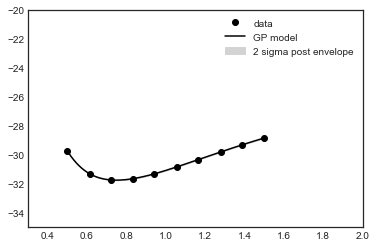

In [14]:
# plot mean predictions with 2 sigma envelope
[mu, sig] = get_sig(gp_samples)

# choose envelope size
mult = 2

# plot data
fig, ax = plt.subplots(1,1)
ax.plot(train_set, train_ens,'ok',label='data')

ax.plot(test_set, mu, '-k',label='GP model')
ax.fill_between(test_set, mu - mult* sig, mu + mult*sig, color='lightgray',label='2 sigma post envelope')

ax.set_xlim(0.3,2)
ax.set_ylim(-35,-20)
plt.legend()

plt.show()

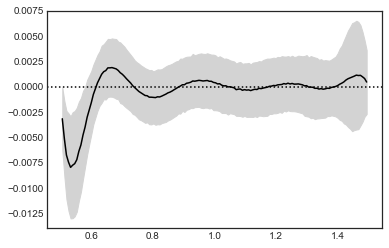

The MAE is 0.02410597810955621 kcal/mole.


In [15]:
# plot data
fig, ax = plt.subplots(1,1)

[errs, MAE] = get_err(test_ens, mu)

ax.plot(test_set, errs, '-k',label='GP model')
ax.fill_between(test_set, errs - mult*sig, errs + mult*sig, color='lightgray',label='2 sigma post envelope')
ax.axhline(0,color='black',ls=':')

plt.show()

print('The MAE is '+str(MAE)+' kcal/mole.')

# Loop through the remaining training set sizes.

current training set size: 50


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [eta_log__]
>Metropolis: [rho_log__]
100%|██████████| 14000/14000 [00:12<00:00, 1108.89it/s]
The number of effective samples is smaller than 10% for some parameters.
100%|██████████| 2000/2000 [00:06<00:00, 297.14it/s]


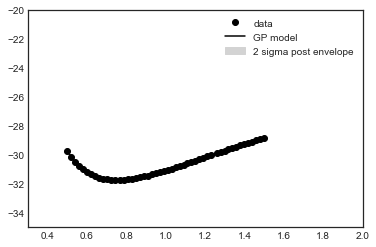

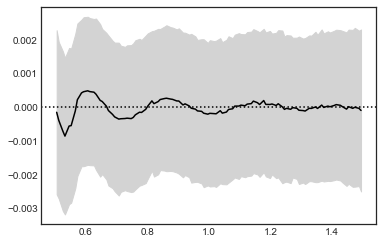

The MAE is 0.0038187278651426087 kcal/mole.
current training set size: 100


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [eta_log__]
>Metropolis: [rho_log__]
100%|██████████| 14000/14000 [00:22<00:00, 630.20it/s]
The number of effective samples is smaller than 10% for some parameters.
100%|██████████| 2000/2000 [00:06<00:00, 306.69it/s]


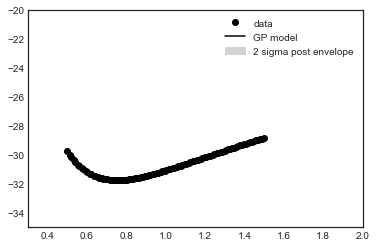

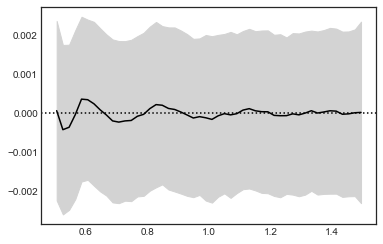

The MAE is 0.0024270615167162053 kcal/mole.
current training set size: 140


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [eta_log__]
>Metropolis: [rho_log__]
  0%|          | 0/14000 [00:00<?, ?it/s]Process ForkPoolWorker-8:
Process ForkPoolWorker-7:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/jonpvandermause/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/jonpvandermause/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/jonpvandermause/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/jonpvandermause/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/jonpvandermause/anaconda3/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/Users/jonpvandermause/anaconda3/lib/python3.6/multiprocessing/pool

KeyboardInterrupt: 

In [11]:
Ms = [50, 100, 140]
N = 150

for n in range(len(Ms)):
    M = Ms[n]
    print('current training set size: '+str(M))
    [train_set, test_set, train_ens, test_ens, train_fours, test_fours]=get_train_test(M, N)
    [gp, lgb_gp] = get_gp_model(train_set, train_ens)
    
    # sample from the posterior
    lgb_gp_trace = posterior_sample(gp,12000)
    
    # get posterior predictive samples
    [data_pred, gp_samples] = ppc_sample(test_set, 2000, lgb_gp, gp)
    
    # plot mean predictions with 2 sigma envelope
    [mu, sig] = get_sig(gp_samples)

    # choose envelope size
    mult = 2

    # plot data
    fig, ax = plt.subplots(1,1)
    ax.plot(train_set, train_ens,'ok',label='data')

    ax.plot(test_set, mu, '-k',label='GP model')
    ax.fill_between(test_set, mu - mult* sig, mu + mult*sig, color='lightgray',label='2 sigma post envelope')

    ax.set_xlim(0.3,2)
    ax.set_ylim(-35,-20)
    plt.legend()

    plt.show()
    
    # plot data
    fig, ax = plt.subplots(1,1)

    [errs, MAE] = get_err(test_ens, mu)

    ax.plot(test_set, errs, '-k',label='GP model')
    ax.fill_between(test_set, errs - mult*sig, errs + mult*sig, color='lightgray',label='2 sigma post envelope')
    ax.axhline(0,color='black',ls=':')

    plt.show()

    print('The MAE is '+str(MAE)+' kcal/mole.')